# Regression

# Q1

In [1]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

from itertools import combinations

import statsmodels.api as sm         
# if the above line raises error, try uninstall scipy and statsmodels, 
# and reinstall use this line:
# pip install scipy==1.14.1 git+https://github.com/statsmodels/statsmodels@v0.14.2
sm.show_versions()

from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.formula.api as smf


INSTALLED VERSIONS
------------------
Python: 3.10.6.final.0
OS: Darwin 22.6.0 Darwin Kernel Version 22.6.0: Mon Feb 19 19:43:41 PST 2024; root:xnu-8796.141.3.704.6~1/RELEASE_ARM64_T8103 arm64
byteorder: little
LC_ALL: None
LANG: None

statsmodels

Installed: 0.14.2 (/opt/homebrew/lib/python3.10/site-packages/statsmodels)

Required Dependencies

cython: Not installed
numpy: 2.1.0 (/opt/homebrew/lib/python3.10/site-packages/numpy)
scipy: 1.14.1 (/opt/homebrew/lib/python3.10/site-packages/scipy)
pandas: 2.2.2 (/opt/homebrew/lib/python3.10/site-packages/pandas)
    dateutil: 2.8.2 (/Users/lesley/Library/Python/3.10/lib/python/site-packages/dateutil)
patsy: 0.5.6 (/opt/homebrew/lib/python3.10/site-packages/patsy)

Optional Dependencies

matplotlib: 3.9.2 (/opt/homebrew/lib/python3.10/site-packages/matplotlib)
    backend: module://matplotlib_inline.backend_inline 
cvxopt: Not installed
joblib: 1.4.2 (/opt/homebrew/lib/python3.10/site-packages/joblib)

Developer Tools

IPython: 8.5.0 (/Use

## a) Resource Downloading
The dataset is stored in folder `data/CCPP`

In [2]:
df = pd.read_excel("../../data/CCPP/Folds5x2_pp.xlsx");
df.head()

AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90

## b) Exploring the data

#### i. Rows and Column

In [3]:
print(df.__len__)
# print(df.describe())

<bound method DataFrame.__len__ of          AT      V       AP     RH      PE
0     14.96  41.76  1024.07  73.17  463.26
1     25.18  62.96  1020.04  59.08  444.37
2      5.11  39.40  1012.16  92.14  488.56
3     20.86  57.32  1010.24  76.64  446.48
4     10.82  37.50  1009.23  96.62  473.90
...     ...    ...      ...    ...     ...
9563  16.65  49.69  1014.01  91.00  460.03
9564  13.19  39.18  1023.67  66.78  469.62
9565  31.32  74.33  1012.92  36.48  429.57
9566  24.48  69.45  1013.86  62.39  435.74
9567  21.60  62.52  1017.23  67.87  453.28

[9568 rows x 5 columns]>


The dataset has 9568 rows and 5 columns.

**Meaning of rows:**

Each row represent a data entry / data point with 4 attributes and 1 label.

**Meaning of columns:**

The first 4 columns each represent a feature, they are:

1. AT: hourly average ambient variables Temperature
2. V: Exhast Vacuum
3. AP: Ambient Pressure
4. RH: Relative Humidity

All of the values in all features are float type and are continuous.

The last column represent the label / target / Y value.

The label is also float and continuous , meaning can be approached as a regression problem.

#### ii. scatterplots

Includes pairwise comparisons between dependent variables, or between independent and dependent variables.

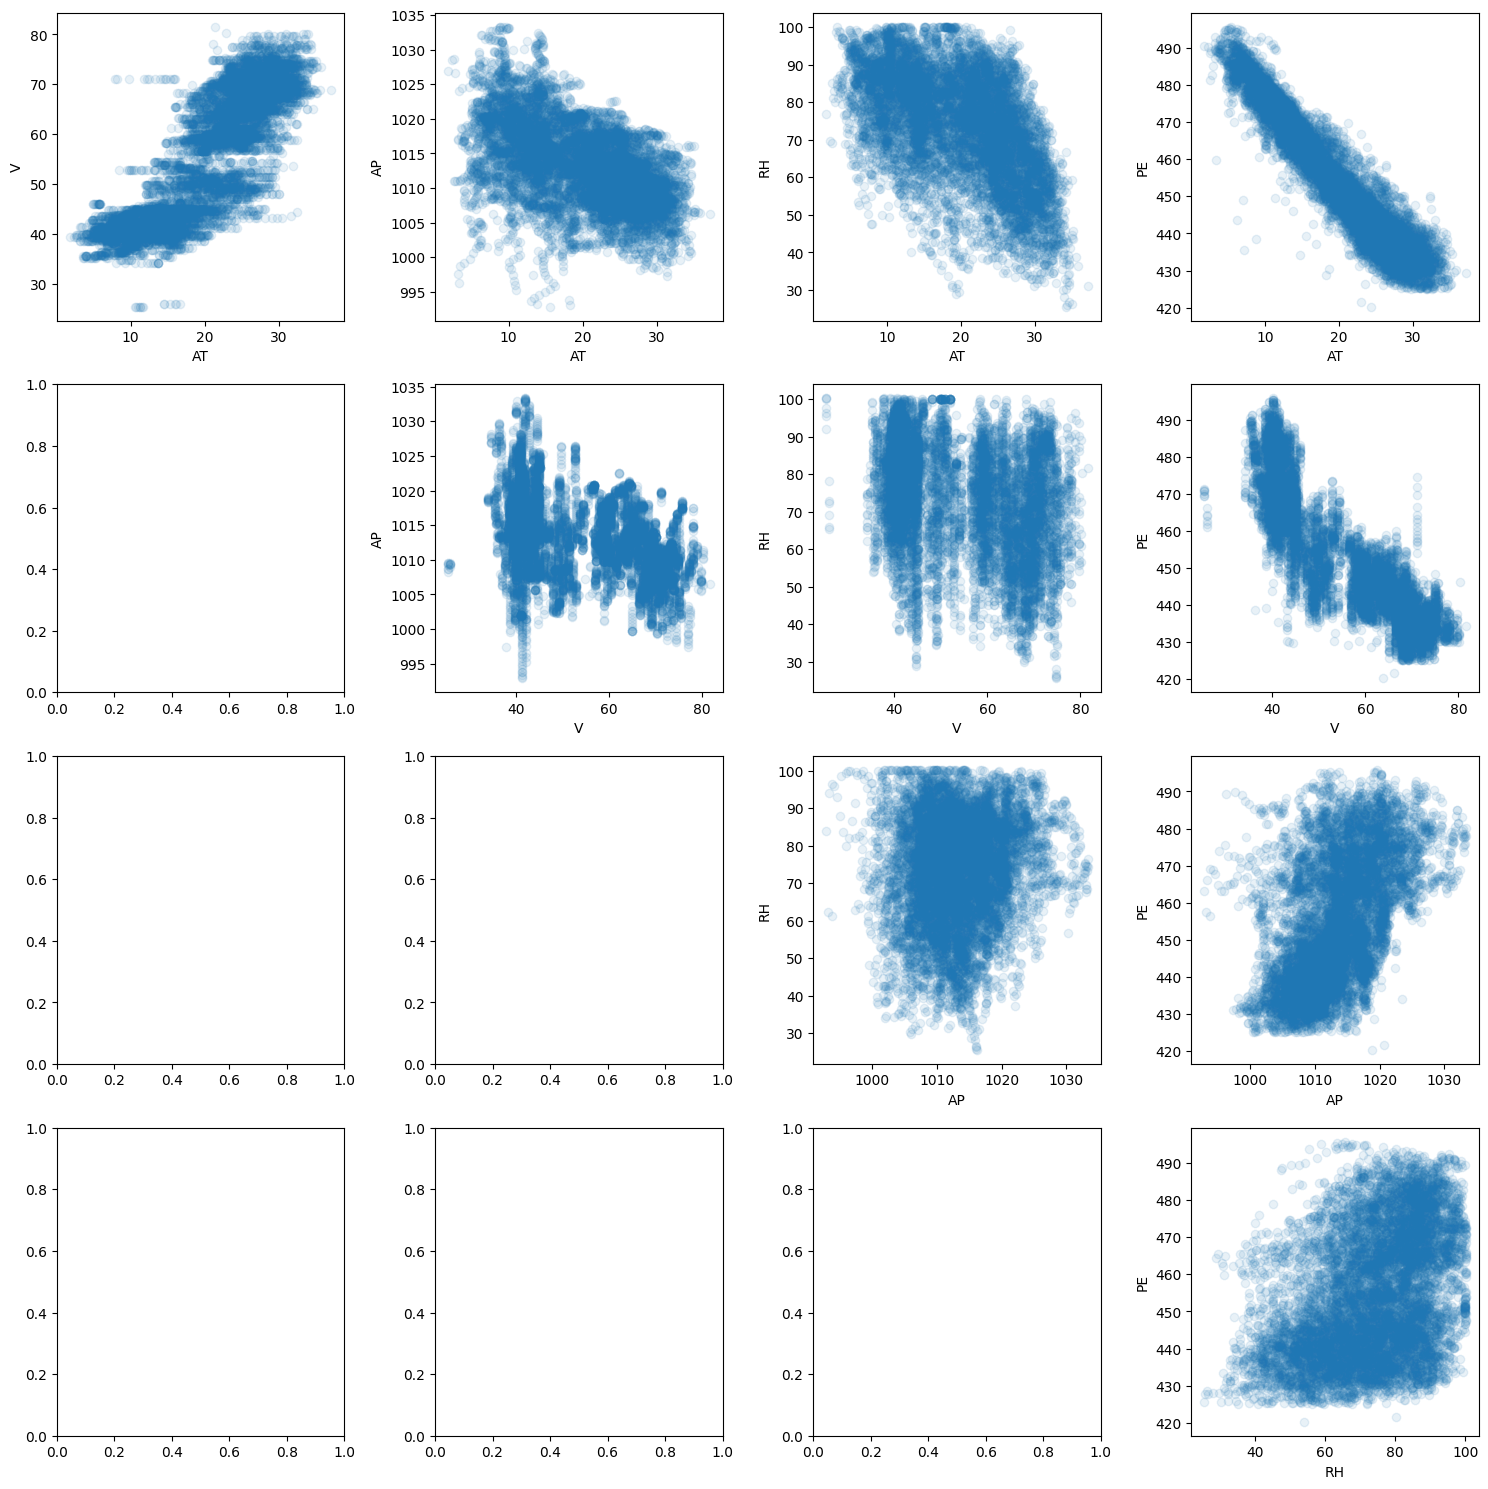

In [4]:
# color_map= {1: 'red', 0: 'blue'}
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
variables = ['AT', 'V', 'AP', 'RH', 'PE']

for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables[i+1:], start=i+1):
        ax = axes[i][j-1] if j > 0 else axes[j][i]  # assigning axes
        ax.scatter(df[var1], df[var2], alpha=0.1)
        ax.set_xlabel(var1)
        ax.set_ylabel(var2)

plt.tight_layout()
plt.show()

**My Findings**:

1. The 9 plots in the first 3 columns are comparisons between dependent variables. From my observation I can tell that *AT* and *V* might have some correlation like a linear relation since the shape is tilted and comparitively smaller variance.

2. Other comparisons between dependent variables does not show correlation that obvious, but there might also be some between *AT* and *RH*. Might need fruther analysis.

3. The 4 plots in the last column are comparisons between the 4 features and the predictor. From the shape of the plots we can tell *AT* and *V* has a bigger chance to have correlation with *PE*. However, *RH* doesn't really show that much a correlation with the predictor *RH*. Therefore it need further analysis like calculating a p-value.

#### iii. Statistics Summary Table

Summarize the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in a table.

In [5]:
df_array = np.array(df) # convert to pandas array for further calculation

# a function that can be used on each variable
def calculate_statistics(data):
    mean = np.mean(data)
    median = np.median(data)
    range_val = np.max(data) - np.min(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    return mean, median, range_val, q1, q3, iqr

# built the table
print(" var\t| Mean\t|Median\t|Range\t|  Q1\t|  Q3\t|  IQR ")
print("-------------------------------------------------------")
# Calculate statistics for each variable
for i, var in enumerate(variables):
    mean, median, range_val, q1, q3, iqr = calculate_statistics(df_array[:, i])
    if (var=="AP"):  # align:)
        print(f"{var}\t|{mean:.2f}|{median:.2f}|{range_val:.2f}\t|{q1:.2f}|{q3:.2f}|{iqr:.2f}")
    else:
        print(f"{var}\t|{mean:.2f}\t|{median:.2f}\t|{range_val:.2f}\t|{q1:.2f}\t|{q3:.2f}\t|{iqr:.2f}")


 var	| Mean	|Median	|Range	|  Q1	|  Q3	|  IQR 
-------------------------------------------------------
AT	|19.65	|20.34	|35.30	|13.51	|25.72	|12.21
V	|54.31	|52.08	|56.20	|41.74	|66.54	|24.80
AP	|1013.26|1012.94|40.41	|1009.10|1017.26|8.16
RH	|73.31	|74.97	|74.60	|63.33	|84.83	|21.50
PE	|454.37	|451.55	|75.50	|439.75	|468.43	|28.68


## c) Simple Linear Regression for each feature

In [6]:
# Divide features and target
X = df.iloc[:,:4] 
y = df.iloc[:, 4]
# train test split # piazza says don't split until question h
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# build simple regression models
def simple_reg_models(feature_name, X, y):
    x = X[[feature_name]]
    
    reg = LinearRegression().fit(x, y)
    r = reg.score(x, y) ** 0.5  # R-squared to r
    if reg.coef_[0] < 0:
        r = -r  # Adjust sign based on coefficient
    return r, reg.coef_[0]      # Also return coefficient for Question e

# Use X, not X_train
simple_results = {}
for feature in X.columns:
    # print(X_train[column])
    r, coef = simple_reg_models(feature, X, y)
    simple_results[feature] = {'r': r, 'coef': coef}
    print(f"{feature} : \nr = {r}, coef = {coef}")
    

AT : 
r = -0.9481284704167593, coef = -2.171319958517783
V : 
r = -0.8697803096577882, coef = -1.1681351265557012
AP : 
r = 0.5184290273615736, coef = 1.4898716733991106
RH : 
r = 0.3897940997901017, coef = 0.455650102262982


`reg.score` function returns the coefficient of determination of the prediction (R^2). 

It is usually used to describe the explatory power of a multiple linear regression. However, for a simple regression model, the professor mentioned during the lecture, F-test and t-test yield the same result. Also, R^2 is positively related to F-stats. Therefore, R^2 is  can also show if this feature is statistically significant or not.

**Note**: The score (R^2) is calculated using test set.

From the results above, we can tell that x1 score and x2 score is higher than 50%. Thus, a conclusion can be drawn: 

Both *x1(AT)* and *x2(V)* **have** statistically significant association with the y label. AT is the strongest predictor of Power Efficiency, explaining about 90.50% of the variance. V is the second strongest predictor, explaining about 75.58% of the variance.

Both *x3(AP)* and *x4(RH)*, on the contrary, do **not** show statistically significant association with the y label. They explaining only 26.23% and 15.76% of the variance in Power Efficiency, respectively.



In [7]:
# rebuild simple regression model using statsmodels
def simple_reg_models_sm(feature_name, X, y):
    x = X[[feature_name]]

    # x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    # print(model.summary())

    print(model.pvalues)

# Use X, not X_train
for feature in X.columns:
    simple_reg_models_sm(feature, X, y)
    

AT    0.0
dtype: float64
V    0.0
dtype: float64
AP    0.0
dtype: float64
RH    0.0
dtype: float64


If only check the p values for the 4 predictors, all of them is statistically significant since they are all essentially 0 ( < 0.05). This result alligns with the following.

##### **Below are the plots to check if the assertions are correct.**

**reference**: [scipy doc for stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) : for calculating r and p value

-0.9481284704167592
0.0


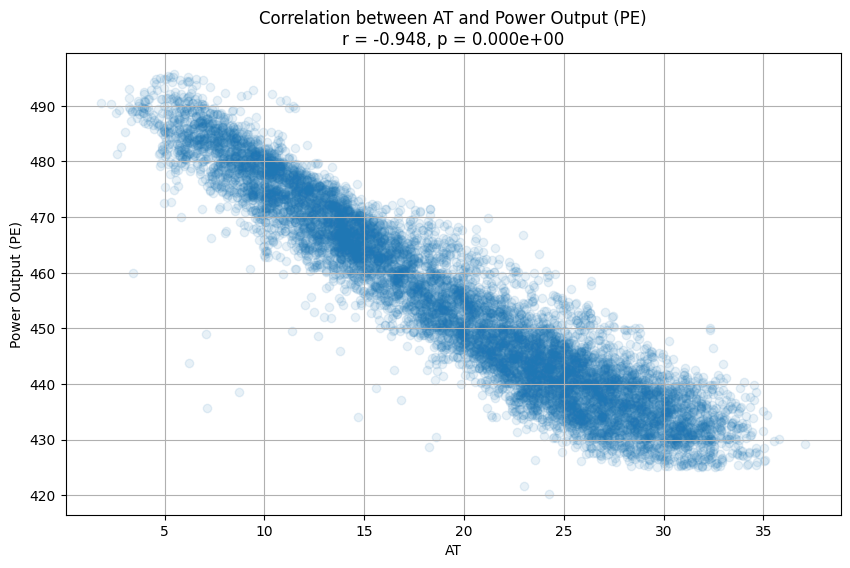

PE: r = -0.948, p = 0.000e+00
-0.8697803096577883
0.0


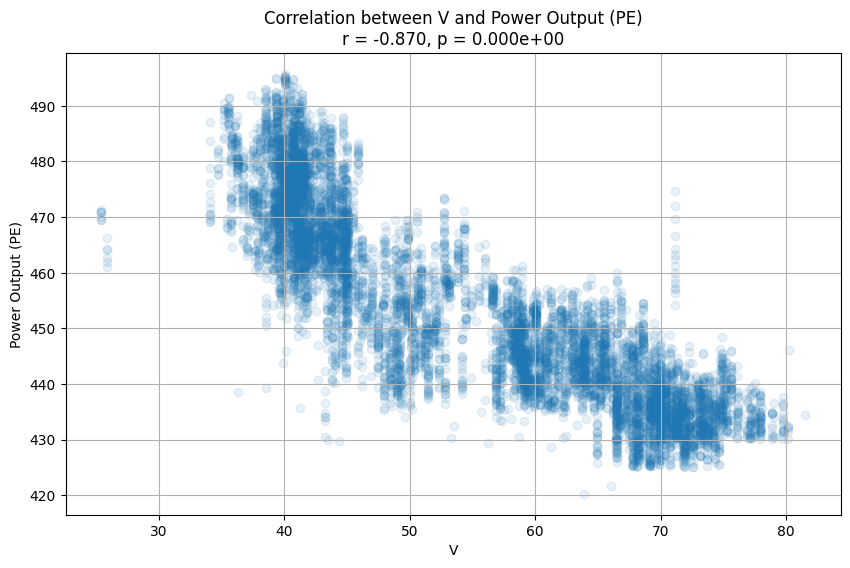

PE: r = -0.870, p = 0.000e+00
0.5184290273615737
0.0


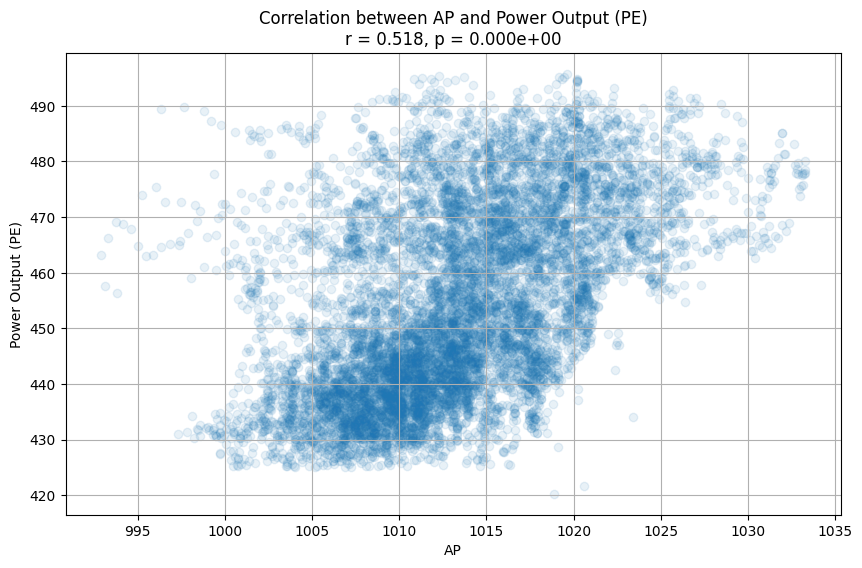

PE: r = 0.518, p = 0.000e+00
0.38979409979010177
0.0


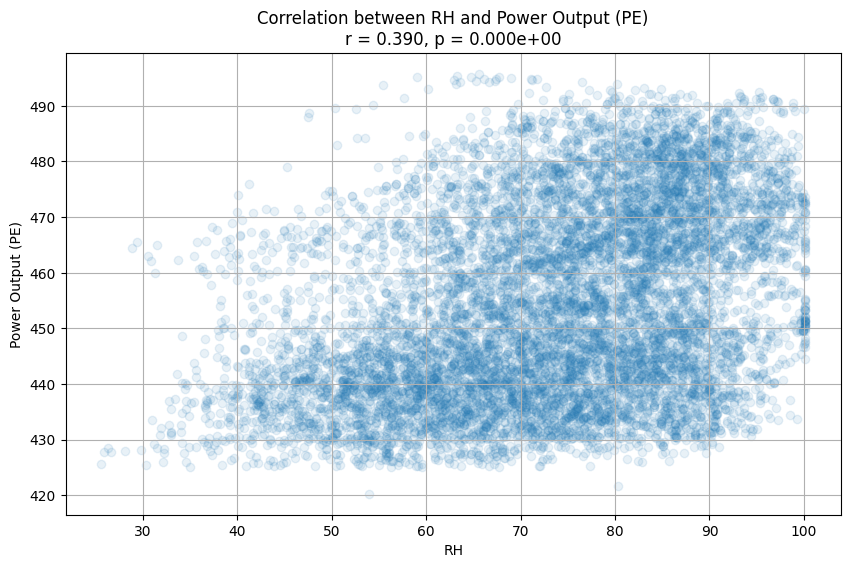

PE: r = 0.390, p = 0.000e+00


In [8]:
# Function to create scatter plot and calculate correlation
def plot_correlation(x, y, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Calculate correlation coefficient and p-value
    r, p = stats.pearsonr(x.values.flatten(), y.values.flatten())
    print(r)
    print(p)

    plt.title(f'Correlation between {xlabel} and {ylabel}\nr = {r:.3f}, p = {p:.3e}')
    plt.grid(True)
    plt.show()

    return r, p

# apply to each feature
for feature in X.columns:
    r, p = plot_correlation(X[[feature]], y, str(feature), 'Power Output (PE)')
    print(f"{var}: r = {r:.3f}, p = {p:.3e}")

Analysis:

1. **AT**: the correlation is very strong and negative(-0.947). The p-value is close to zero, meaning extremely high statisticcal significance.
2. **V**: The correlation is strong and negative (-0.870). The p-value is also close to zero, meaning extremely high statisticcal significance.
3. **AP**: The correlation is moderate and positive (0.520). The p-value is essentially zero, indicating high statistical significance.
4. **RH** : The correlation is between weak to moderate and positive (0.388). The p-value is extremely small (3.010e-273), indicating high statistical significance.

Interpretation: 

1. The assertion that AT (x1) and V (x2) have statistically significant associations with PE is strongly supported. Both have very strong correlations (|r| > 0.8) and extremely low p-values.

2. However, the second assertion that AP (x3) and RH (x4) aren't statistically significant  with PE is not supported by these results. Both show statistically significant correlations with PE (p-values are essentially zero), although their correlations are weaker than those of AT and V.

3. The negative correlations for AT and V suggest that as temperature or exhaust vacuum increases, power output tends to decrease. The positive correlations for AP and RH suggest as pressure or humidity increases, power output tends to increase, but the relationship is not so strong.

Thinking:

**Why ap and rh have low p-value but low predictive power?**

1. large sample size.
2. It might be because AP and RH only has a weak but consistent association.
3. correaltion not linear. If the correlation is not linear, then it doesn't really fit into linear regression?
4. There might be some correlations between variables that leads to this?

##### Outliers Detection using studentized residuals

According to piazza, I used studentized residuals.

**reference**:

[statsmodels doc for `outliers_influence.OLSInfluence`](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.OLSInfluence.html) 
-> There's a method called `resid_studentized_internal`



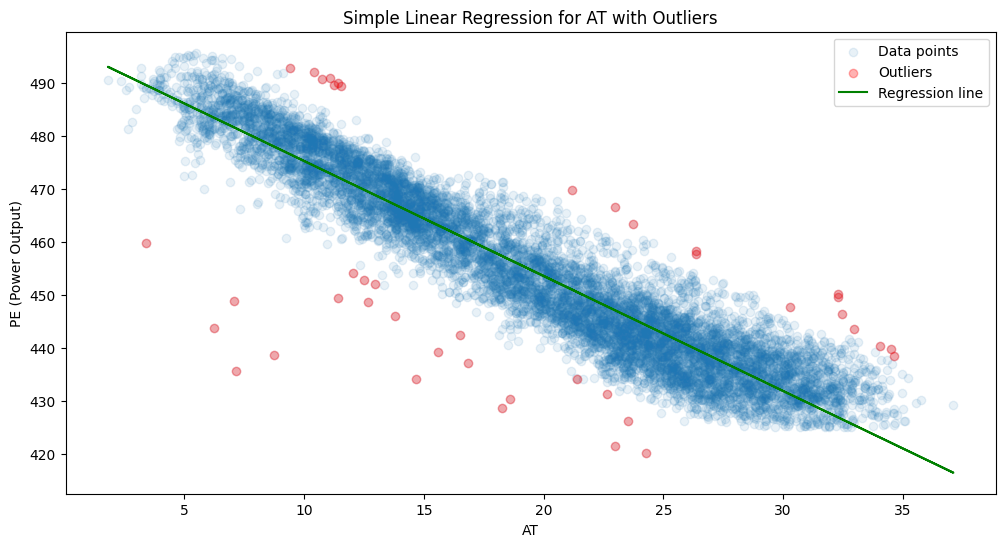

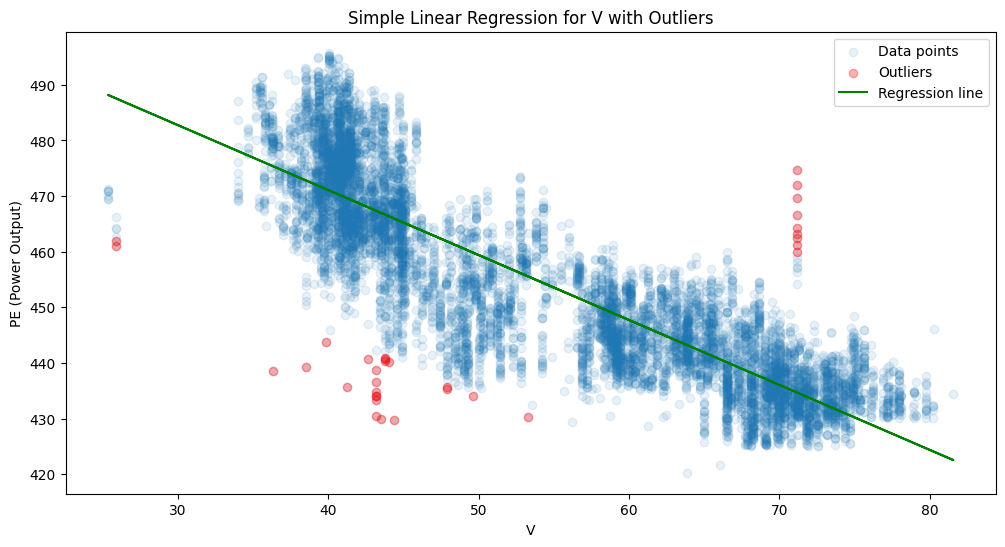

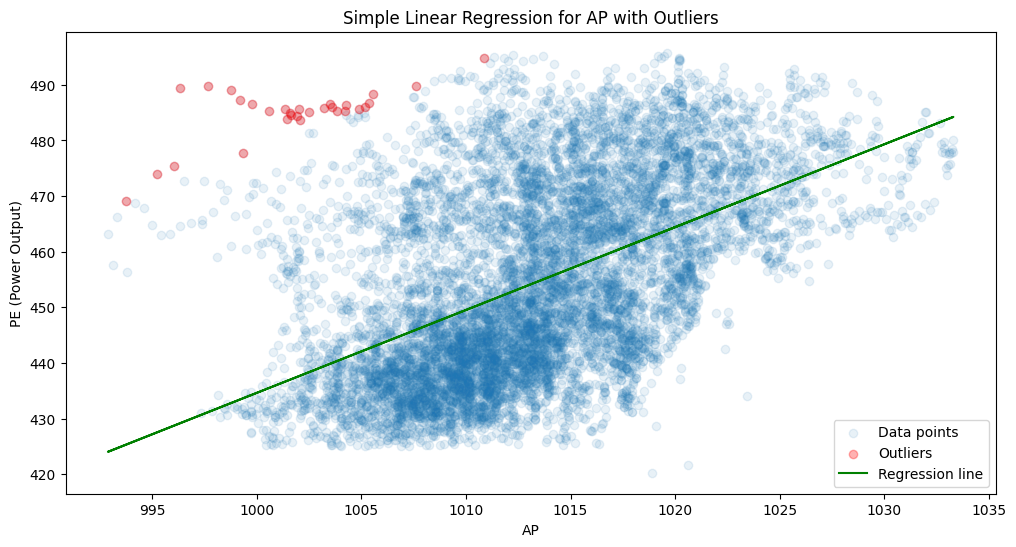

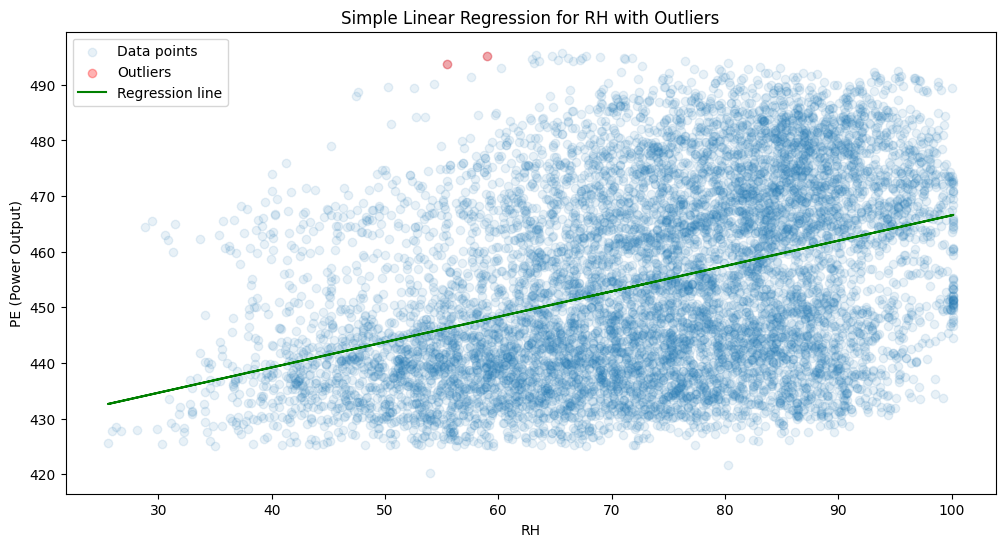


Summary of outliers across all predictors:
AT: 42 outliers
V: 33 outliers
AP: 30 outliers
RH: 2 outliers


In [9]:
def detect_outliers_stud_res(X, y, predictor_name):
    # Add constant term to the predictor
    X = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    
    # Calculate studentized residuals
    influence = OLSInfluence(model)
    studentized_residuals = influence.resid_studentized_external
    
    # Identify outliers (using absolute studentized residuals > 3 as a threshold)
    outliers = abs(studentized_residuals) > 3
    
    # print(f"\nSimple Linear Regression Results for {predictor_name}:")
    # print(model.summary())

    # Uncomment the lines below to see all the outliers
    # print(f"\nOutliers for {predictor_name} (index: studentized residual):")
    # for idx, is_outlier in enumerate(outliers):
    #     if is_outlier:
    #         print(f"Index {idx}: {studentized_residuals[idx]:.3f}")

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.scatter(X.iloc[:, 1], y, alpha=0.1, label='Data points')
    plt.scatter(X.iloc[:, 1][outliers], y[outliers], color='red', alpha=0.3, label='Outliers')  # # Highlight outliers
    
    # Add regression line
    plt.plot(X.iloc[:, 1], model.predict(X), color='green', label='Regression line')
    
    plt.xlabel(predictor_name)
    plt.ylabel('PE (Power Output)')
    plt.title(f'Simple Linear Regression for {predictor_name} with Outliers')
    plt.legend()
    plt.show()
    
    return model, outliers, studentized_residuals

# Perform regression and outlier detection for each predictor
results = {}
for feature in X.columns:
    X_feature = X[[feature]]
    model, outliers, studentized_residuals = detect_outliers_stud_res(X_feature, y, feature)
    results[feature] = {
        'model': model,
        'outliers': outliers,
        'studentized_residuals': studentized_residuals
    }

# Summary of outliers across all predictors
print("\nSummary of outliers across all predictors:")
for feature in X.columns:
    num_outliers = np.sum(results[feature]['outliers'])
    print(f"{feature}: {num_outliers} outliers")


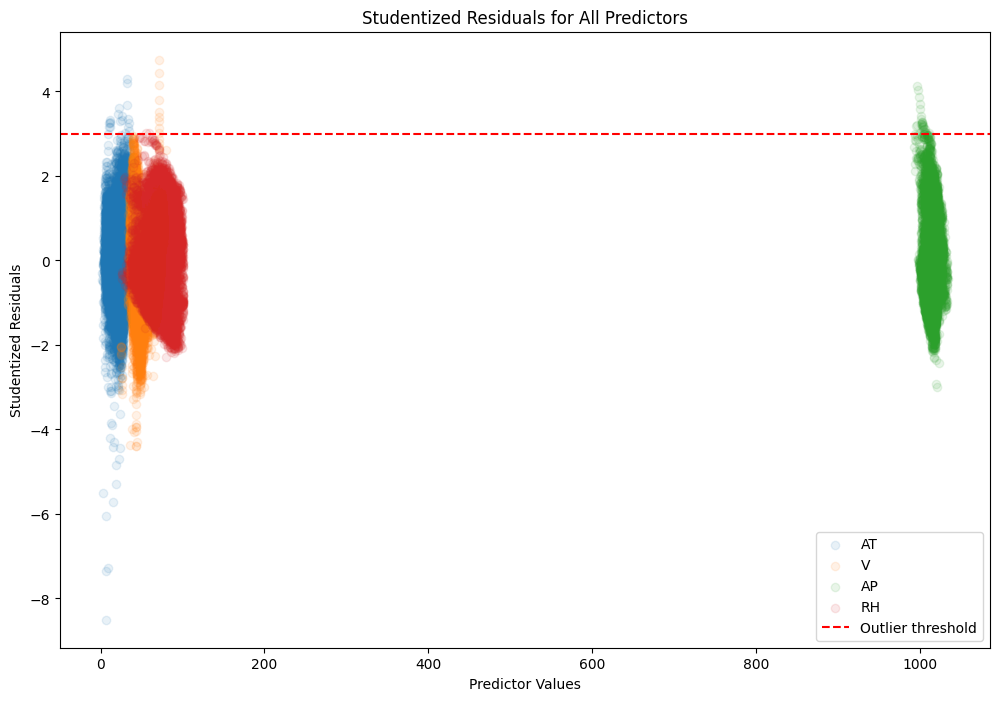

In [10]:
# Plot studentized residuals for all predictors
plt.figure(figsize=(12, 8))
for feature in X.columns:
    plt.scatter(df[feature], results[feature]['studentized_residuals'], alpha=0.1, label=feature)

plt.axhline(y=3, color='r', linestyle='--', label='Outlier threshold')
# plt.axhline(y=-3, color='r', linestyle='--')
plt.xlabel('Predictor Values')
plt.ylabel('Studentized Residuals')
plt.title('Studentized Residuals for All Predictors')
plt.legend()
plt.show()

The decision to remove outliers should be made cautiously and based on a thorough understanding of the data and the physical processes involved in the power plant operations.

For AT, AP and RH, Extreme temperature events could be real and important events, not necessarily outliers to be removed. But for V (Exhaust Vacuum), unusual values might indicate equipment issues or measurement errors.

I left the dataset as it is for now.

## d) Mulitple Regression Model for all features

**References**:

[statsmodels doc for OLS](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html)

In [11]:
# fit a mulitple regression model
reg_mul = LinearRegression().fit(X, y)
print("Multi regression R score squared: ", reg_mul.score(X, y))

Multi regression R score squared:  0.9286960898122536


According to the textbook and the lecture, F-Test is used to show the overall significance of the model i.e. whether there is a linear relationship between all of the X variables considered together and Y. 

Consider the definition if βj:
We interpret βj as the average effect on Y of a one unit increase in Xj , holding all other predictors fixed.

So F statistic result can be used to reject the null hypothesis on βj.

In [12]:
# calculate F-statistic
X_intercept = sm.add_constant(X)
X_intercept.head()

const     AT      V       AP     RH
0    1.0  14.96  41.76  1024.07  73.17
1    1.0  25.18  62.96  1020.04  59.08
2    1.0   5.11  39.40  1012.16  92.14
3    1.0  20.86  57.32  1010.24  76.64
4    1.0  10.82  37.50  1009.23  96.62

In [13]:
# train the model using OLS and its fit function
results = sm.OLS(y, X_intercept).fit()
# print out the F-stats
A = np.identity(len(results.params))
A = A[1:,:]
print(results.f_test(A))

<F test: F=31138.26676366785, p=0.0, df_denom=9.56e+03, df_num=4>


The above code I used this reference: [Calculating F-statistic](https://medium.com/analytics-vidhya/f-statistic-understanding-model-significance-using-python-c1371980b796)

The results show that the given model got an F-stat score of 3885066.80. It also displays the two degrees of freedom: df1 = 3 and df2 = 9.56e+03. So to find the F-critical value we can look up the f-distribution table for the alpha value of 0.05.

**Decision**:
31138.26676366785 is greater than 2.6049. This means F test statistic is in the rejection region (p-value < .05), reject H0. 

**Conclusion**:
There is evidence that at least one independent variable affects Y

## e) Regression Comparison Analysis

**references**:

[Python Dictionary Comprehension](https://www.geeksforgeeks.org/python-dictionary-comprehension/)

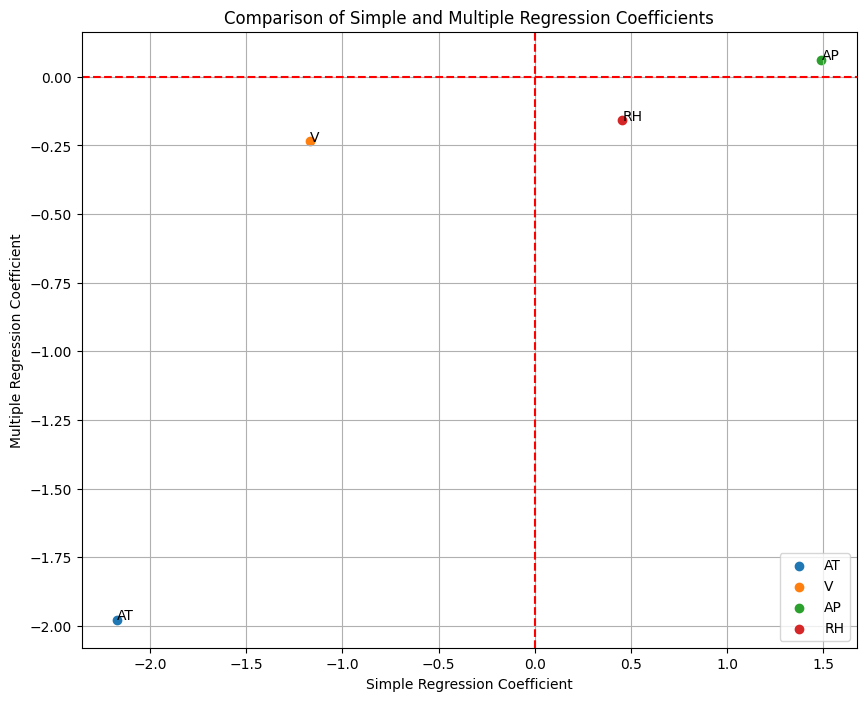


Comparison of coefficients:
AT:
  Simple regression: -2.1713
  Multiple regression: -1.9775
V:
  Simple regression: -1.1681
  Multiple regression: -0.2339
AP:
  Simple regression: 1.4899
  Multiple regression: 0.0621
RH:
  Simple regression: 0.4557
  Multiple regression: -0.1581


In [14]:
X = df.iloc[:, :4]
# Prepare data for the plot
# store in dictionary 
plot_data = {
    feature: {
        'simple_coef': simple_results[feature]['coef'],
        'multi_coef': reg_mul.coef_[i]
    } for i, feature in enumerate(X.columns)
}

# Create the plot
plt.figure(figsize=(10, 8))
for feature, data in plot_data.items():
    plt.scatter(data['simple_coef'], data['multi_coef'], label=feature)
    plt.annotate(feature, (data['simple_coef'], data['multi_coef']))

plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Simple Regression Coefficient')
plt.ylabel('Multiple Regression Coefficient')
plt.title('Comparison of Simple and Multiple Regression Coefficients')
plt.legend()
plt.grid(True)
plt.show()

# Explicitly print comparison
print("\nComparison of coefficients:")
for feature in X.columns:
    print(f"{feature}:")
    print(f"  Simple regression: {simple_results[feature]['coef']:.4f}")
    print(f"  Multiple regression: {reg_mul.coef_[list(X.columns).index(feature)]:.4f}")

**Interpretation**:

The plot helps visualize how the importance of predictors changes when moving from simple to multiple regression:

Points close to the diagonal line indicate predictors whose influence remains similar in both models.
Points far from the diagonal suggest predictors whose influence changes when other variables are considered.

AT likely remains an important predictor in both models.
for V, AP and RH, their influence might decrease in the multiple regression model.

## f) Non-linear associations

**references**:

[Implementation of Polynomial Regression](https://www.geeksforgeeks.org/python-implementation-of-polynomial-regression/)

[Polynomial Regression in Python using scikit-learn](https://data36.com/polynomial-regression-python-scikit-learn/)

[Polynomial regression using statsmodel](https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html)

[statsmodels doc for fit](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit.html#statsmodels.regression.linear_model.OLS.fit)
-> I used this to get the pvalues


##### i.
I used two different methods. The main difference is the method used for training the model: statsmodels and sklearn.linear_model.

**Below is the code using `statsmodels`.**

/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


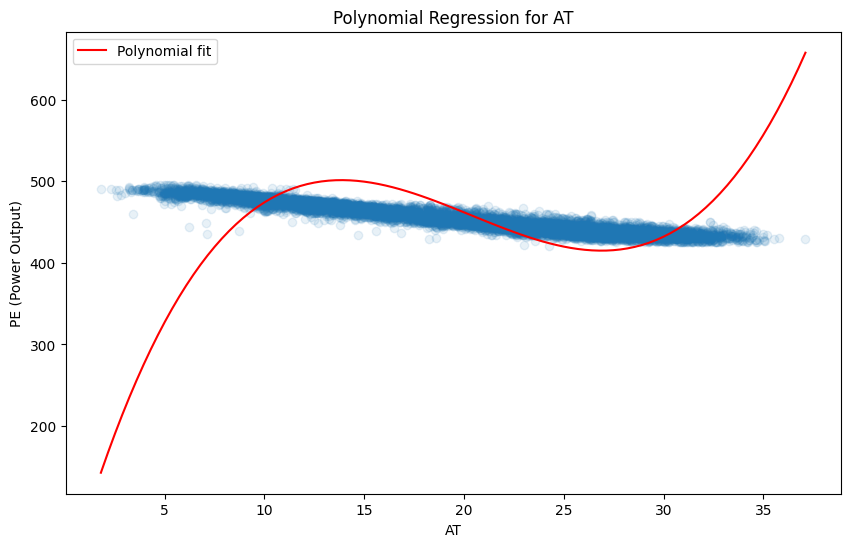

/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


AT  coefficients:
  β1 (AT^1): 87.3234
  β2 (AT^2): -4.7728
  β3 (AT^3): 0.0781


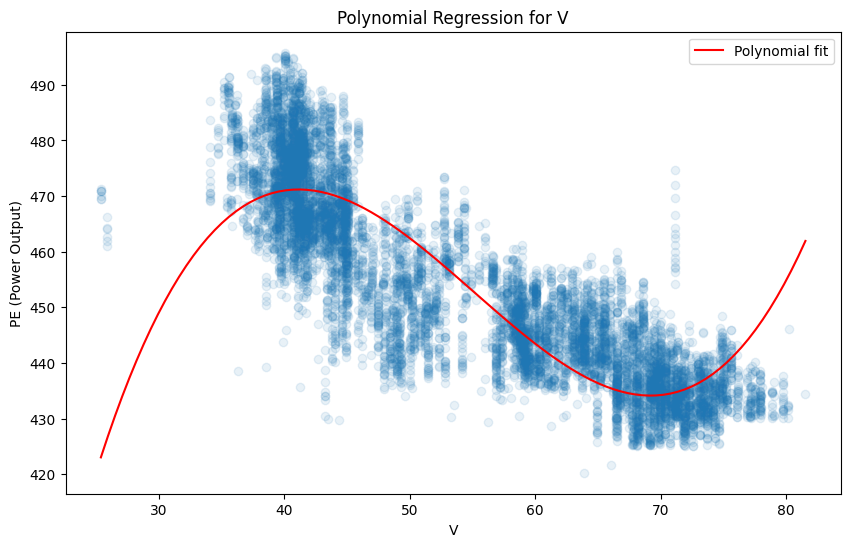

V  coefficients:
  β1 (V^1): 28.5727
  β2 (V^2): -0.5538
  β3 (V^3): 0.0033


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


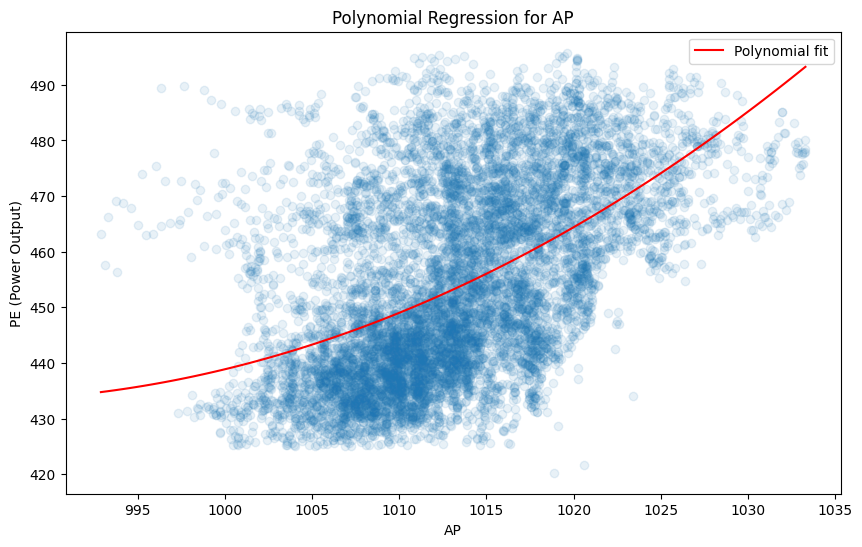

AP  coefficients:
  β1 (AP^1): 25.2558
  β2 (AP^2): -0.0500
  β3 (AP^3): 0.0000


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


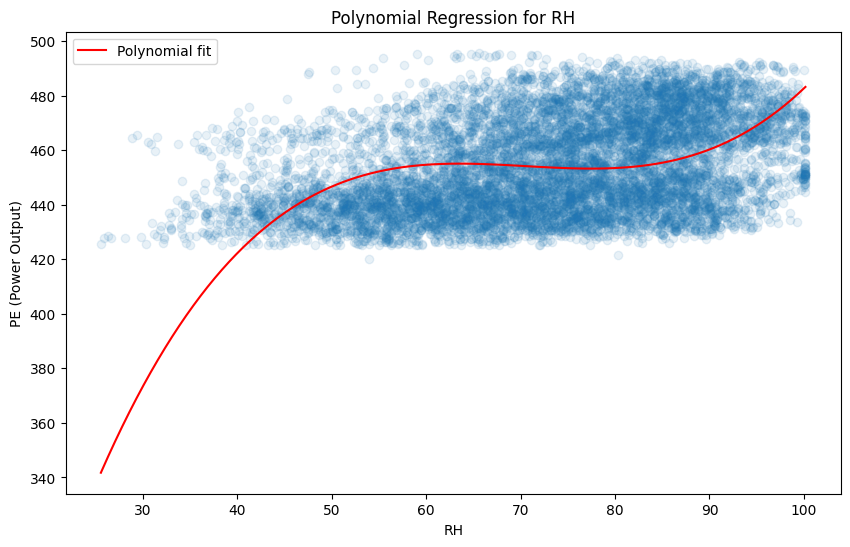

RH  coefficients:
  β1 (RH^1): 19.7151
  β2 (RH^2): -0.2824
  β3 (RH^3): 0.0013


In [15]:
X = df.iloc[:,:4] # make sure X is intact

def fit_poly_regression(x, y, feature_name):
    poly_features = PolynomialFeatures(degree=3, include_bias=False)    # degree is fixed to 3
    x_poly = poly_features.fit_transform(x)

    model = sm.OLS(y, x_poly).fit()
    y_pred = model.predict(x_poly)
    
    # Generate a range of values for plotting the polynomial regression line
    x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    x_range_poly = poly_features.transform(x_range)
    y_range_pred = model.predict(x_range_poly) 

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.1)
    plt.plot(x_range, y_range_pred, color='r', label='Polynomial fit')  
    plt.xlabel(feature_name)
    plt.ylabel('PE (Power Output)')
    plt.title(f'Polynomial Regression for {feature_name}')
    plt.legend()
    plt.show()

    return model, poly_features

# Perform polynomial regression for each feature
for feature in X.columns:
    X = df[[feature]]
    model, poly_features = fit_poly_regression(X, y, feature)
    
    # show the coefficients
    print(feature, " coefficients:")
    for i, coef in enumerate(model.params):  # Changed to model.params for OLS coefficients
        print(f"  β{i+1} ({feature}^{i+1}): {coef:.4f}")


##### ii. Below is the code using `sklearn.linear_model`


Polynomial Regression Results for AT:
R-squared: 0.9119
Coefficients:
  β1 (AT^1): -0.6103
  β2 (AT^2): -0.1251
  β3 (AT^3): 0.0027


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


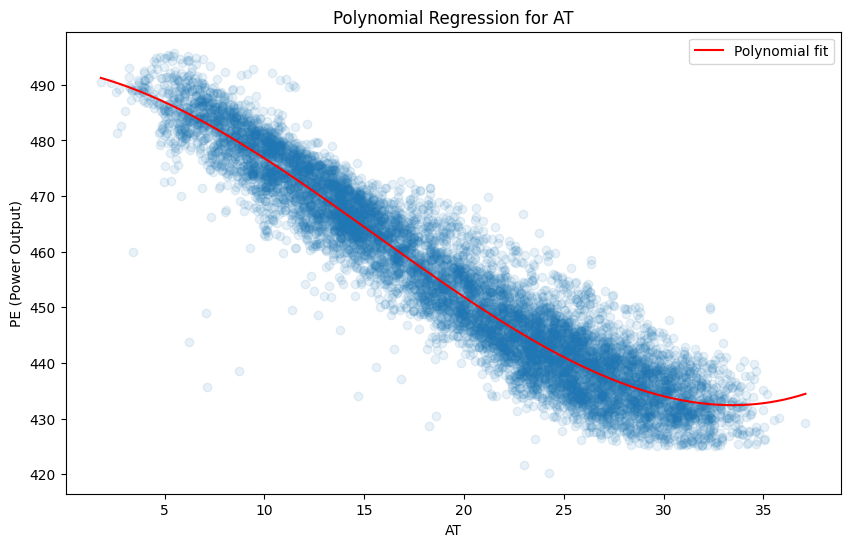


Polynomial Regression Results for V:
R-squared: 0.7750
Coefficients:
  β1 (V^1): -2.1444
  β2 (V^2): -0.0027
  β3 (V^3): 0.0001


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


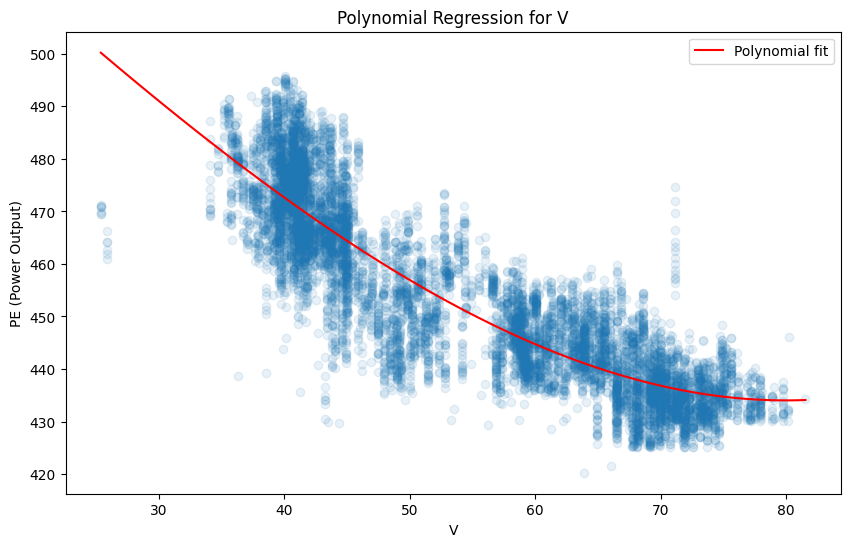


Polynomial Regression Results for AP:
R-squared: 0.2975
Coefficients:
  β1 (AP^1): -15460.8657
  β2 (AP^2): 15.2163
  β3 (AP^3): -0.0050


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


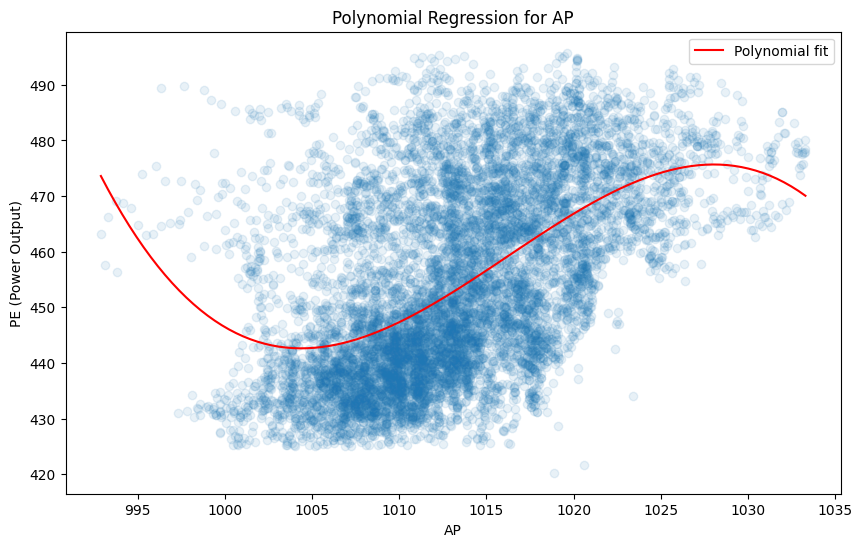


Polynomial Regression Results for RH:
R-squared: 0.1537
Coefficients:
  β1 (RH^1): -1.7292
  β2 (RH^2): 0.0321
  β3 (RH^3): -0.0002


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


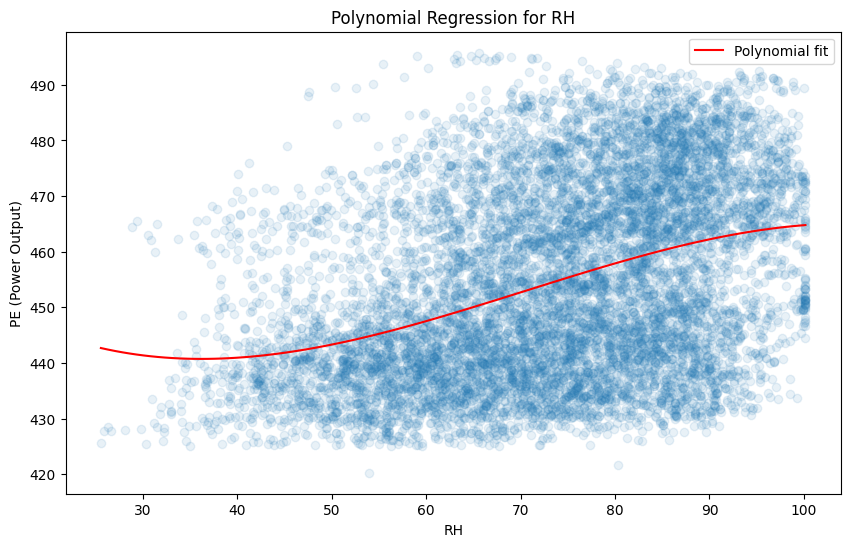


R-squared comparison:
AT: 0.9119
V: 0.7750
AP: 0.2975
RH: 0.1537


In [16]:
X = df.iloc[:,:4] # make sure X is intact

# defien a model with higher degrees and train it 
def fit_polynomial_regression(X, y):
    poly_features = PolynomialFeatures(degree=3, include_bias=False)    # degree is fixed to 3
    X_poly = poly_features.fit_transform(X)
    
    model = LinearRegression().fit(X_poly, y)
    # model = sm.OLS(y, X_poly).fit()
    y_pred = model.predict(X_poly)
    r2 = r2_score(y, y_pred)
    
    return model, poly_features, r2

# define a function to make plot for each feature 
def plot_polynomial_fit(X, y, model, poly_features, feature_name):
    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    X_range_poly = poly_features.transform(X_range)
    y_pred = model.predict(X_range_poly)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, alpha=0.1)
    plt.plot(X_range, y_pred, color='r', label='Polynomial fit')
    plt.xlabel(feature_name)
    plt.ylabel('PE (Power Output)')
    plt.title(f'Polynomial Regression for {feature_name}')
    plt.legend()
    plt.show()

# Perform polynomial regression for each feature
results = {}
for feature in X.columns:
    X = df[[feature]]
    model, poly_features, r2 = fit_polynomial_regression(X, y)
    # store calculated stats
    results[feature] = {
        'model': model,
        'poly_features': poly_features,
        'r2': r2
    }
    
    # show the coeficients
    print(f"\nPolynomial Regression Results for {feature}:")
    print(f"R-squared: {r2:.4f}")
    print("Coefficients:")
    for i, coef in enumerate(model.coef_):
        print(f"  β{i+1} ({feature}^{i+1}): {coef:.4f}")

    plot_polynomial_fit(X, y, model, poly_features, feature)

# Compare R-squared values
print("\nR-squared comparison:")
for feature, result in results.items():
    print(f"{feature}: {result['r2']:.4f}")

By observing the plots, the one using sklearn is more reasonable.

In [17]:
# Identify the predictor with the strongest nonlinear association
maxRR = max(results, key=lambda x: results[x]['r2'])   # compare using R^2 value
print(f"Feature with biggest R^2: {maxRR}")

Feature with biggest R^2: AT


In addition to the above, we can also compare R^2 value of AT when fitting linear regression models:

> 0.9481284704167592 ^ 2 = 0.8989

Since 0.9119 is slightly greater than 0.8989, AT fits better with nonlinear polynomial regression model.

Although from the stats we can tell that feature AT has the highest R^2 value for non-linear association, the actual coefficients of this feature with higher degrees are not big:

β2 (X^2): -0.0027, 

β3 (X^3): 0.0001

That means the shape of the model does not really show much curvature. Therefore, I think it might be better to compare using R^2 value and coefficients in higher degrees combined.

In [18]:
# print(results["AT"]["model"].coef_)

# compare using x^2 coefficient
max2coef = max(results, key=lambda x: abs(results[x]['model'].coef_[1]))
print(f"\nPredictor with biggest x^2 coefficent: {max2coef}")

# compare using x^3 coefficient
max3coef = max(results, key=lambda x: abs(results[x]['model'].coef_[2]))
print(f"\nPredictor with biggest x^3 coefficent: {max3coef}")


Predictor with biggest x^2 coefficent: AP

Predictor with biggest x^3 coefficent: AP


To answer this question, I used Claude.ai for advise to identify nonlinear associations. Here's the answer:
> R-squared values: Higher R-squared values indicate a better fit. Compare these to the R-squared values from the simple linear regressions. If the polynomial R-squared is significantly higher, it suggests a nonlinear association.
> 
> Coefficients: Look at the magnitudes of β2 and β3. If these are relatively large compared to β1, it indicates nonlinearity.
> 
> Plots: Visually inspect the plots. If the polynomial curve fits the data points better than a straight line would, it suggests a nonlinear relationship.
> 
> Comparison across predictors: The predictor with the highest R-squared in the polynomial regression might be the one with the strongest nonlinear association with the response.
> 
> Based on this analysis, you can draw conclusions about the presence of nonlinear associations:
>
> If a predictor shows a significantly higher R-squared in the polynomial model compared to the linear model, and the plot shows a clear nonlinear pattern, you can conclude there's evidence of a nonlinear association.
> 
> If the R-squared values are similar to those from linear regression, and the plots don't show clear curvature, the relationship might be adequately captured by a linear model.


Considering the R^2 value for AP is not that high, the nonlinear association is not that outstanding. 

revious we know r-value for linear association of AP is 0.5184290273615737. Therefore the R^2 value is 0.268, which is only lightly lower than the nonlinear R^2 value.  For AP, nonlinear association might seem a better fit, but the improvement is not big. Inaddition, it still does not have a high explanatory power if looking at R^2 value.

**Conclusion**: 

No predictor shows a significantly higher R-squared in the polynomial model compared to the linear model.

The plot for AP shows a clear nonlinear pattern with curvature, but the R-squared value is similar to that from linear regression. This means the relationship might be adequately captured by a linear model.

**There's not enough evidence of a nonlinear association.**

## g) Interaction predictor analysis

I chose significance level of 0.05 here.

**Reference**:

1. [Python program to get all pairwise combinations from a list](https://www.geeksforgeeks.org/python-program-to-get-all-pairwise-combinations-from-a-list/) -> I used `itertools.combinations`

2. [statsmodels doc for fit](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit.html#statsmodels.regression.linear_model.OLS.fit)
-> I used this to print the summary of my model, to see the stats 

3. [statsmodels doc for RegressionResults](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults) 
-> I used this to get the pvalues

In [19]:
X = df.iloc[:,:4] # make sure X is intact
features = X.columns    # for convenience and readability
y = df['PE']

# Create interaction terms
interaction_terms = []
for var1, var2 in combinations(features, 2):    # reference: Python program to get all pairwise combinations from a list
    name = f'{var1}_{var2}'
    X[name] = X[var1] * X[var2]
    interaction_terms.append(name)

# Prepare the data for regression
X_comb = X[features.tolist() + interaction_terms]
# Add constant term to the predictor variables
X_comb = sm.add_constant(X_comb)

# train the model
model = sm.OLS(y, X_comb).fit()

# Print the summary of the regression results
print(model.summary())      # reference: statsmodels doc for fit

# Extract p-values and create a DataFrame for easy viewing
p_values = model.pvalues    # reference: statsmodels doc for RegressionResults
p_value_df = pd.DataFrame({'p_value': p_values})
p_value_df = p_value_df.sort_values('p_value')  # sort accrording to pvalues

print("\nSorted p-values:") #
print(p_value_df)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        23:56:52   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        685.7825     78.640      8.721      0.0

In [20]:
# Identify statistically significant interaction terms
alpha = 0.05  # Significance level (usually 0.05)
significant_interactions = p_value_df[
    (p_value_df['p_value'] < alpha )
]

print("\nStatistically significant interaction terms (p < 0.05):")
print(significant_interactions)


Statistically significant interaction terms (p < 0.05):
             p_value
AT_V   3.333358e-117
const   3.231607e-18
AT_RH   1.216944e-10
V       1.371251e-08
V_AP    2.877026e-07
AP_RH   3.360557e-02
RH      4.225213e-02
AP      4.735732e-02


There are 4 combined terms that show statistical significance: `AT_V`, `AT_RH`, `V_AP` and `AP_RH` (decendently).

Therefore evidence of association of interactions of predictors with the response exists.

## h) Improve the Model with Interactions and Nonlinearities

**references**: 

[Backward elimination with detailed explanation](https://groverjatin.medium.com/short-python-code-for-backward-elimination-with-detailed-explanation-52894a9a7880)

In [21]:
X = df.iloc[:,:4] # make sure X is intact

# Split the data (70% 30 %)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Baseline model
def baseline_model(X_train, X_test, y_train, y_test):
    model = sm.OLS(y_train, X_train).fit()
    train_mse = mean_squared_error(y_train, model.predict(X_train))
    test_mse = mean_squared_error(y_test, model.predict(X_test))
    return train_mse, test_mse

# imporoved model with interactions and quadratic terms
def add_features(X):
    advanced_X = X.copy()
    
    # Add quadratic terms - deprecated
    # poly_features = PolynomialFeatures(degree=2, include_bias=False)    # degree is fixed to 3
    # X_poly = poly_features.fit_transform(X)
    # print(X_poly)
    # print("len", len(X_poly))
    # print("col_len", len(X_poly[0]))
    # advanced_X[f"{X}^2"], advanced_X[f"{X}^3"] = X_poly[:, 1], X_poly[:, 2]
    # Add quadratic terms manually
    for feature in features:
        advanced_X[f'{feature}^2'] = X[feature]**2
        # advanced_X[f'{feature}^3'] = X[feature]**3
    
    # Add interaction terms
    for var1, var2 in combinations(features, 2):
        advanced_X[f'{var1}_{var2}'] = X[var1] * X[var2]
    for var1, var2, var3 in combinations(features, 3):
        advanced_X[f'{var1}_{var2}_{var3}'] = X[var1] * X[var2] * X[var3]
    advanced_X["fourComb"] = X["AT"] * X["V"] * X["AP"] * X["RH"]

    return advanced_X

# Remove insignificant variables
def remove_variables(X, y, alpha=0.05):   # deafult alpha set to 0.05
    print("Before: ", X.columns.tolist())
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    # use Backward selection method to select features
    while True:
        p_values = model.pvalues[1:]  # get p value, excluding the constant term
        max_p_value = p_values.max()
        if max_p_value > alpha:
            max_p_feature = p_values.idxmax()
            X = X.drop(max_p_feature, axis=1)
            model = sm.OLS(y, X).fit()
        else:
            break
    print("After:  ", X.columns.tolist()[1:])
    return X.columns.tolist()[1:]  # Exclude the constant term

# Create advanced features
X_train_advanced = add_features(X_train)
X_test_advanced = add_features(X_test)
# Remove insignificant variables
significant_features = remove_variables(X_train_advanced, y_train)
# Final advanced model
X_train_final = X_train_advanced[significant_features]
X_test_final = X_test_advanced[significant_features]

def advanced_model(X_train, X_test, y_train, y_test):
    model = sm.OLS(y_train, X_train_final).fit()
    train_mse = mean_squared_error(y_train, model.predict(X_train))
    test_mse = mean_squared_error(y_test, model.predict(X_test))
    return train_mse, test_mse


Before:  ['AT', 'V', 'AP', 'RH', 'AT^2', 'V^2', 'AP^2', 'RH^2', 'AT_V', 'AT_AP', 'AT_RH', 'V_AP', 'V_RH', 'AP_RH', 'AT_V_AP', 'AT_V_RH', 'AT_AP_RH', 'V_AP_RH', 'fourComb']
After:   ['AT', 'V', 'AP', 'RH', 'AT^2', 'AP^2', 'RH^2', 'AT_V', 'AT_AP', 'AT_RH', 'V_AP', 'V_RH', 'AP_RH', 'AT_V_AP', 'AT_V_RH', 'AT_AP_RH', 'V_AP_RH', 'fourComb']


In [22]:
# Compare models
baseline_train_mse, baseline_test_mse = baseline_model(X_train, X_test, y_train, y_test)
advanced_train_mse, advanced_test_mse = advanced_model(X_train_final, X_test_final, y_train, y_test)

print("Baseline Model:")
print(f"Train MSE: {baseline_train_mse}")
print(f"Test MSE: {baseline_test_mse}")

print("\nAdvanced Model:")
print(f"Train MSE: {advanced_train_mse}")
print(f"Test MSE: {advanced_test_mse}")

Baseline Model:
Train MSE: 25.668556093937507
Test MSE: 25.096901176932416

Advanced Model:
Train MSE: 17.544350657183788
Test MSE: 18.214323916171487


The significant features in the advanced model: 

AT, V, AP, RH, 

AT^2, AP^2, RH^2, 

AT_V, AT_AP, AT_RH, V_AP, V_RH, AP_RH

AT_V_AP, AT_V_RH, AT_AP_RH, V_AP_RH

fourComb

Which means only V^2 is removed

## i) KNN

**references**:

[sklearn doc for KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

[KNN Regression with Python](https://aamir07.medium.com/knn-regression-with-python-c11cbc5aa9a8) --> I used this as an example to build the models

In [23]:
# Function to perform KNN
def knn_regression(X_train, X_test, y_train, y_test):
    train_MSE = []
    test_MSE = []
    for k in range(1, 101): # range of k (excluding 101)
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        train_pred = knn.predict(X_train)
        test_pred = knn.predict(X_test)
        
        train_MSE.append(mean_squared_error(y_train, train_pred))
        test_MSE.append(mean_squared_error(y_test, test_pred))
    
    return train_MSE, test_MSE

# KNN regression for raw features
raw_train_MSE, raw_test_MSE = knn_regression(X_train, X_test, y_train, y_test)

# KNN regression for normalized features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)    
X_test_norm = scaler.transform(X_test)
norm_train_MSE, norm_test_MSE = knn_regression(X_train_norm, X_test_norm, y_train, y_test)

# Find best k for raw and normalized features
k_range = range(1, 101)
best_k_raw = k_range[np.argmin(raw_test_MSE)]
best_k_raw_value = raw_test_MSE[best_k_raw]
print(f"Best k for raw features: {best_k_raw}, value = {best_k_raw_value}")

best_k_norm = k_range[np.argmin(norm_test_MSE)]
best_k_norm_value = norm_test_MSE[best_k_norm]
print(f"Best k for normalized features: {best_k_norm}, value = {best_k_norm_value}")

Best k for raw features: 5, value = 15.794225175122872
Best k for normalized features: 4, value = 14.659872398467435


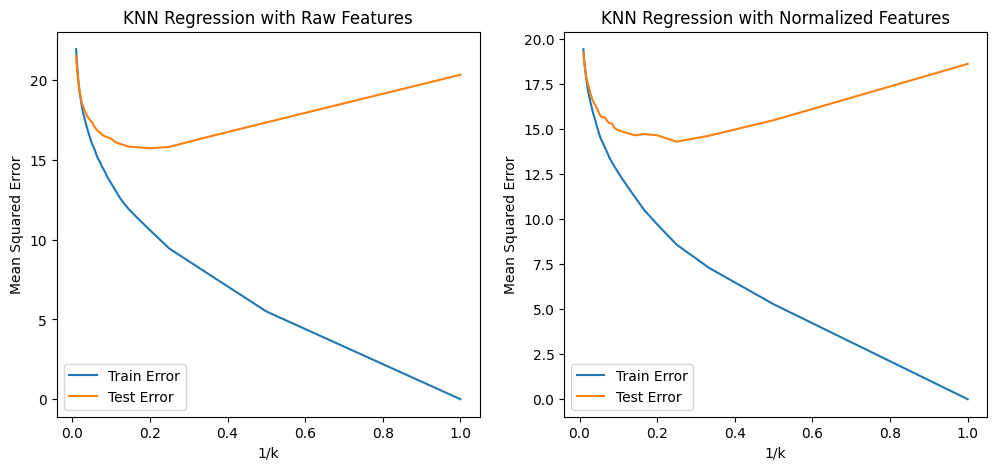

In [24]:
# Plot MSE
plt.figure(figsize=(12, 5))
# Raw features
plt.subplot(1, 2, 1)
plt.plot([1/k for k in k_range], raw_train_MSE, label='Train Error')
plt.plot([1/k for k in k_range], raw_test_MSE, label='Test Error')
plt.xlabel('1/k')
plt.ylabel('Mean Squared Error')
plt.title('KNN Regression with Raw Features')
plt.legend()
# Normalized features
plt.subplot(1, 2, 2)
plt.plot([1/k for k in k_range], norm_train_MSE, label='Train Error')
plt.plot([1/k for k in k_range], norm_test_MSE, label='Test Error')
plt.xlabel('1/k')
plt.ylabel('Mean Squared Error')
plt.title('KNN Regression with Normalized Features')
plt.legend()


## j) Comparison: KNN model & linear reg model

for KNN model, I chose the one with normalized features, because the MSE value is lower (14.66 < 15.79).

In [25]:
# linear model using improved model from h
linear_model = sm.OLS(y_train, X_train_final).fit()
linear_pred = linear_model.predict(X_test_final)
linear_MSE = mean_squared_error(y_test, linear_pred)
linear_r2 = r2_score(y_test, linear_pred)

# Best KNN Model
KNN_model = KNeighborsRegressor(n_neighbors=best_k_norm)    # best k from part i
KNN_model.fit(X_train_norm, y_train)
KNN_pred = KNN_model.predict(X_test_norm)
KNN_MSE = mean_squared_error(y_test, KNN_pred)
KNN_r2 = r2_score(y_test, KNN_pred)

# Print results
print("Model Comparison:")
print(f"Linear Regression - MSE: {linear_MSE:.4f}, R^2: {linear_r2:.4f}")
print(f"KNN (Normalized)  - MSE: {KNN_MSE:.4f}, R^2: {KNN_r2:.4f}")

print("\nResidual Analysis:")
linear_residuals = y_test - linear_pred
KNN_model_residuals = y_test - KNN_pred
print(f"Linear Regression - Mean: {np.mean(linear_residuals):.4f}, Std: {np.std(linear_residuals):.4f}")
print(f"KNN (Normalized)  - Mean: {np.mean(KNN_model_residuals):.4f}, Std: {np.std(KNN_model_residuals):.4f}")

Model Comparison:
Linear Regression - MSE: 18.2143, R^2: 0.9379
KNN (Normalized)  - MSE: 14.3057, R^2: 0.9512

Residual Analysis:
Linear Regression - Mean: 0.0195, Std: 4.2678
KNN (Normalized)  - Mean: 0.0681, Std: 3.7817


**references**:
[Evaluating a machine learning model](https://www.jeremyjordan.me/evaluating-a-machine-learning-model/)

**Analysis**:

Performance:

Look at the MSE and R^2 values for each model. KNN model has the lower MSE and higher R^2 on the test set
Therefore the KNN model is considered the best performing model.
It suggests that there are more complex relationships that the linear model couldn't capture.

Residual Analysis:

I calculated the mean and standard deviation of the residuals.
The linear model has a lower mean value, which indicates a more unbiased prediction.
The standard deviation of KNN is lower, meaning its residuals have lower variance

Computational Efficiency:

The linear regression model is generally faster for making predictions, especially on large datasets. KNN is usually more computationally expensive.

# Q2

### (a)

An inflexible method.

Justification: With a very large sample size and less predictors, we have a lot of data to estimate a relatively simple model. Inflexible methods tend to have lower variance and are harder to be overfitting. The large sample size allows even simple models to get the underlying patterns .

### (b)

A flexible method.

Justification: If p >> n, inflexible methods are easy to underfit the data. Flexible methods can better get complex relationships between the many predictors and the response. However, we must be careful to avoid overfitting. We can do that through regularization techniques maybe.

### (c)

A flexible method.

Justification: Highly non-linear relationships are difficult to calculate with inflexible methods like linear regression. Flexible methods like KNN, decision trees, or neural networks are able to find the complex, non-linear patterns in the data more effectively.

### (d)

An inflexible method.

Justification: High error variance indicates a lot of noise. Flexible methods might try to fit this noise, leading to overfitting and less generalization. Inflexible methods are less sensitive to noise and tend to capture only the most consistent and ovbious pattern.

# Q3

Check the pdf [here](./Q3.pdf).

# References

1. [Calculating F-statistic](https://medium.com/analytics-vidhya/f-statistic-understanding-model-significance-using-python-c1371980b796)

2. [scipy doc for stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) : for calculating r and p value

3. statsmodels

    [statsmodels doc for OLS](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) 
    -> I use this for Multi Linear Regression

    [statsmodels doc for fit](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit.html#statsmodels.regression.linear_model.OLS.fit) 
    -> I used this to print the summary of my model, to see the stats 

    [statsmodels doc for RegressionResults](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults)  -> I used this to get the pvalues

    [Polynomial regression using statsmodel](https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html)

4. Polynomial Regression: for Question 1 f

    [Implementation of Polynomial Regression](https://www.geeksforgeeks.org/python-implementation-of-polynomial-regression/)

    [Polynomial Regression in Python using scikit-learn](https://data36.com/polynomial-regression-python-scikit-learn/)

5. Python

    [Python Dictionary Comprehension](https://www.geeksforgeeks.org/python-dictionary-comprehension/)

    [Python program to get all pairwise combinations from a list](https://www.geeksforgeeks.org/python-program-to-get-all-pairwise-combinations-from-a-list/) -> I used `itertools.combinations`

6. feature selection 

    [Backward elimination with detailed explanation](https://groverjatin.medium.com/short-python-code-for-backward-elimination-with-detailed-explanation-52894a9a7880)

7. KNN

    [sklearn doc for KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

    [KNN Regression with Python](https://aamir07.medium.com/knn-regression-with-python-c11cbc5aa9a8) --> I used this as an example to build the models

8. [Evaluating a machine learning model](https://www.jeremyjordan.me/evaluating-a-machine-learning-model/)
